In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
len(os.listdir('/content/gdrive/MyDrive/PMEmo/mel_spec'))

18212

In [25]:
import os
import csv
import json

import librosa
import soundfile as sf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn as nn
from torchvision.models import resnet18
import torch.optim as optim

#### Создаем папку с аудиозаписями длиной в 1 секунду и csv аннотацию 

In [ ]:
with open('/content/gdrive/MyDrive/PMEmo/annotation.csv', 'w') as file:
          writer = csv.writer(file)
          writer.writerows([['song_id', 'arousal', 'valence']])

def save_csv(music, music_name, sr, arousal_sec, valence_sec, counter):
  music = music[counter]
  sf.write(f'/content/gdrive/MyDrive/PMEmo/music/{music_name}_{counter}.wav', music, sr)
  with open('/content/gdrive/MyDrive/PMEmo/annotation.csv', 'a') as file:
    writer = csv.writer(file)
    writer.writerows([[f'{music_name}_{counter}', arousal_sec, valence_sec]])

def make_dataset(song_dir, annotaion_dir):
  df = pd.read_csv(annotaion_dir)
  for elem in sorted(os.listdir(song_dir), key=lambda x: int(x[:x.index('.')])):
    music, sr = librosa.load(f'{song_dir}/{elem}', mono=True, sr=None)
    start_time = librosa.time_to_samples(15, sr=sr)
    music = music[start_time:]
    music_length = music.shape[0] // sr
    if music_length == 0:
      continue
    frame_duration = 1
    frame_length = int(frame_duration * sr)
    music = librosa.util.frame(music, frame_length=frame_length, hop_length=frame_length, axis=0)
    music_name = int(elem.split('.')[0])

    arousal = list(df[df['musicId'] == music_name]['Arousal(mean)'].values)
    valence = list(df[df['musicId'] == music_name]['Valence(mean)'].values)

    for counter, index in enumerate(range(0, len(arousal), 2)):
      if (counter == len(music)) or (index+1 == len(arousal)):
        continue
      arousal_sec = (arousal[index] + arousal[index+1])/2
      valence_sec = (valence[index] + valence[index+1])/2
      save_csv(music, music_name, sr, arousal_sec, valence_sec, counter)


In [ ]:
song_dir = '/content/gdrive/MyDrive/PMEmo2019/chorus'
annotaion_dir = '/content/gdrive/MyDrive/PMEmo2019/dynamic_annotations.csv'
make_dataset(song_dir, annotaion_dir)

#### Создаем датасет с log-mel-spectrogram

In [123]:
def spec_to_img(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [124]:
def song_preprocess(music_dir, song):
    music, sr = librosa.load(os.path.join(music_dir, song), mono=True, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=music, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    spectrogram = librosa.power_to_db(spectrogram,top_db=80)
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, 87 - spectrogram.shape[1])]], mode='constant')
    return(spec_to_img(np.float32(spectrogram)))

In [125]:
def make_dataset(music_dir, annot_dir):
  annot_df = pd.read_csv(annot_dir)
  for song in sorted(os.listdir(music_dir)):
    mel_spec = song_preprocess(music_dir, song)
    if mel_spec is None:
        continue
    music_id = song.split('.')[0]
    np.save(f'/content/gdrive/MyDrive/PMEmo/mel_spec/{music_id}.npy', mel_spec)

In [126]:
music_dir = '/content/gdrive/MyDrive/PMEmo/music'
annot_dir = '/content/gdrive/MyDrive/PMEmo/annotation.csv'
make_dataset(music_dir, annot_dir)

<ipython-input-123-014131facfb9>:6: RuntimeWarning: invalid value encountered in true_divide
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)


In [143]:
class MusicDataset(Dataset):
  def __init__(self):
    self.mel_spec_dir = '/content/gdrive/MyDrive/PMEmo/mel_spec'
    self.annot_df = pd.read_csv('/content/gdrive/MyDrive/PMEmo/annotation.csv')
    self.music_name = os.listdir(self.mel_spec_dir)

  def __len__(self):
    return len(self.music_name)

  def __getitem__(self, idx):
    music =  self.music_name[idx]
    mel_spec = torch.tensor(np.load(os.path.join(self.mel_spec_dir, music)), dtype=torch.float)/255
    arousal = torch.tensor(self.annot_df[self.annot_df['song_id'] == music.split('.')[0]]['arousal'].values[0], dtype=torch.float)
    valence = torch.tensor(self.annot_df[self.annot_df['song_id'] == music.split('.')[0]]['valence'].values[0], dtype=torch.float)
    return music.split('.')[0], mel_spec, arousal, valence

In [155]:
dataset = MusicDataset()

In [156]:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
print(train_size)
print(valid_size)

14547
3637


In [157]:
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [158]:
music_name, music, arousal, valence = next(iter(train_data))
music_new_shape = torch.unsqueeze(music, 1)
music_new_shape.shape

torch.Size([128, 1, 128, 87])

In [159]:
arousal.shape

torch.Size([128])

In [160]:
model = resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

In [161]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
metric = nn.L1Loss()

In [162]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [163]:
model(music_new_shape).shape

torch.Size([128, 1])

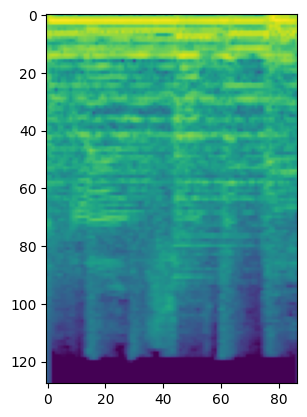

In [164]:
plt.imshow(music[2])

In [118]:
!rm -r /content/gdrive/MyDrive/PMEmo/CNN

In [119]:
!rm -r /content/gdrive/MyDrive/PMEmo/LSTM_weights

rm: cannot remove '/content/gdrive/MyDrive/PMEmo/LSTM_weights': No such file or directory


In [ ]:
!rm -r /content/gdrive/MyDrive/PMEmo/CNN/weights

In [ ]:
!rm -r /content/gdrive/MyDrive/PMEmo/CNN/weights2

In [165]:
with open('/content/gdrive/MyDrive/PMEmo/CNN/arousal_history.csv', 'w') as file:
          writer = csv.writer(file)
          writer.writerows([['epoch', 'train_loss', 'train_metric', 'valid_loss', 'valid_metric']])

In [166]:
def train_model(model, n_epochs, optimizer, criterion, target, metric):
    model.to(device)
    
    history = {
    'train_losses': [],
    'valid_losses': [],
    'train_metrics': [],
    'valid_metrics': []
    }

    best_metrics = {'epoch': 0, 'valid_loss': 0, 'valid_metric': 0}
    
    for epoch in range(n_epochs):
        train_losses_iter = []
        train_metrics_iter = []
        model.train()
        j=0
        for _, music, arousal, valence in train_data:
            if j % 10 == 0:
              print(f'{j} итерация в train')
            j+=1
            music, arousal, valence = music.to(device), arousal.to(device), valence.to(device)
            music = torch.unsqueeze(music, 1)
            
            out = model(music)
            if target == 'arousal':
                loss = torch.sqrt(criterion(out.squeeze(), arousal))
                metric_res = metric(out.squeeze(), arousal)
            elif target == 'valence':
                loss = torch.sqrt(criterion(out.squeeze(), valence))
                metric_res = metric(out.squeeze(), valence)
            
            train_losses_iter.append(loss.item())
            train_metrics_iter.append(metric_res.item())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        history['train_losses'].append(np.mean(train_losses_iter))
        history['train_metrics'].append(np.mean(train_metrics_iter))

        valid_losses_iter = []
        valid_metrics_iter = []
        model.eval()

        i=0
        for _, music, arousal, valence in valid_data:
            i+= 1
            if i % 10 == 0:
                print(f'{i} итерация в valid')
    
            music, arousal, valence = music.to(device), arousal.to(device), valence.to(device)
            music = torch.unsqueeze(music, 1)

            out = model(music)
            if target == 'arousal':
                loss = torch.sqrt(criterion(out.squeeze(), arousal))
                metric_res = metric(out.squeeze(), arousal)
            elif target == 'valence':
                loss = torch.sqrt(criterion(out.squeeze(), valence))
                metric_res = metric(out.squeeze(), valence)

            valid_losses_iter.append(loss.item())
            valid_metrics_iter.append(metric_res.item())

        history['valid_losses'].append(np.mean(valid_losses_iter))
        history['valid_metrics'].append(np.mean(valid_metrics_iter))
        with open('/content/gdrive/MyDrive/PMEmo/CNN/arousal_history.csv', 'a') as file:
          writer = csv.writer(file)
          writer.writerows([[epoch, round(history["train_losses"][-1], 4),
                             round(history["train_metrics"][-1], 4),
                             round(history["valid_losses"][-1], 4),
                             round(history["valid_metrics"][-1], 4)]])
        
        if (best_metrics['valid_loss'] == 0) or (best_metrics['valid_loss'] > history["valid_losses"][-1]):
          best_metrics['epoch'] = epoch
          best_metrics['valid_loss'] = history["valid_losses"][-1]
          best_metrics['valid_metric'] = history["valid_metrics"][-1]
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/PMEmo/CNN/arousal_weights/best_model.pt')
          print(f"best results: epoch {best_metrics['epoch']}, valid loss {best_metrics['valid_loss']}, valid metric {best_metrics['valid_metric']}")

          with open('/content/gdrive/MyDrive/PMEmo/CNN/arousal_best_res.json', 'w') as outfile:
            json.dump(best_metrics, outfile)

        torch.save(model.state_dict(), '/content/gdrive/MyDrive/PMEmo/CNN/arousal_weights/each_epochs.pt')
        if epoch == 100:
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/PMEmo/CNN/arousal_weights/100_epochs.pt')
        if epoch == 199:
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/PMEmo/CNN/arousal_weights/200_epochs.pt')
        
        print(f'epoch: {epoch}\n'
        f'train: loss {history["train_losses"][-1]:.4f}\n'
        f'train: metric {history["train_metrics"][-1]:.4f}\n'
        f'valid: loss {history["valid_losses"][-1]:.4f}\n'
        f'valid: metric {history["valid_metrics"][-1]:.4f}')
        print(f'{"-"*35}')
        print() 
    return history      

In [ ]:
history = train_model(model, 200, optimizer, criterion, 'arousal', metric)